Please note contents of this notebook will produce different values to the lecture notes due to differing seed values and python versions.

## Load Libraries & Data

In [1]:
import platform
print(platform.python_version())

3.9.13


In [2]:
import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from matplotlib import pyplot
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression
from pandas.plotting import scatter_matrix
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [3]:
tsy_tickers = ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30',
               'TREAST', # -- U.S. Treasury securities held by the Federal Reserve ( Millions of Dollars )
               'FYGFDPUN', # -- Federal Debt Held by the Public ( Millions of Dollars )
               'FDHBFIN', # -- Federal Debt Held by Foreign and International Investors ( Billions of Dollars )
               'GFDEBTN', # -- Federal Debt: Total Public Debt ( Millions of Dollars )
               'BAA10Y', # -- Baa Corporate Bond Yield Relative to Yield on 10-Year
              ]

start = datetime.datetime(2010, 1, 1)
tsy_data = web.DataReader(tsy_tickers, 'fred', start).dropna(how='all').ffill()
tsy_data['FDHBFIN'] = tsy_data['FDHBFIN'] * 1000
tsy_data['GOVT_PCT'] = tsy_data['TREAST'] / tsy_data['GFDEBTN']
tsy_data['HOME_PCT'] = tsy_data['FYGFDPUN'] / tsy_data['GFDEBTN']
tsy_data['FOREIGN_PCT'] = tsy_data['FDHBFIN'] / tsy_data['GFDEBTN']

In [4]:
return_period = 3

Y = tsy_data.loc[:, ['DGS3MO', 'DGS2', 'DGS10']].shift(-return_period)
Y.columns = [col+'_pred' for col in Y.columns]

X = tsy_data.loc[:, ['DGS1MO', 'DGS3MO', 'DGS1', 'DGS2', 'DGS5', 'DGS7', 'DGS10', 'DGS30', 'GOVT_PCT', 'HOME_PCT', 'FOREIGN_PCT', 'BAA10Y']]

dataset = pd.concat([Y, X], axis=1).dropna().iloc[::return_period, :]
Y = dataset.loc[:, Y.columns]
X = dataset.loc[:, X.columns]

In [5]:
dataset.head()

,DGS3MO_pred,DGS2_pred,DGS10_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOVT_PCT,HOME_PCT,FOREIGN_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2010-01-06,0.04,0.95,3.85,0.03,0.06,0.40,1.01,2.60,3.33,3.85,4.70,0.060799,0.649352,0.303598,2.49
2010-01-11,0.05,0.94,3.76,0.01,0.04,0.35,0.95,2.58,3.32,3.85,4.74,0.060799,0.649352,0.303598,2.47
2010-01-14,0.05,0.92,3.68,0.02,0.05,0.34,0.94,2.51,3.23,3.76,4.63,0.060800,0.649352,0.303598,2.46
2010-01-20,0.06,0.86,3.66,0.03,0.05,0.31,0.92,2.45,3.16,3.68,4.54,0.060800,0.649352,0.303598,2.48
2010-01-25,0.08,0.87,3.68,0.02,0.06,0.30,0.86,2.39,3.12,3.66,4.55,0.060800,0.649352,0.303598,2.56


In [6]:
dataset.tail()

,DGS3MO_pred,DGS2_pred,DGS10_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOVT_PCT,HOME_PCT,FOREIGN_PCT,BAA10Y
DATE,,,,,,,,,,,,,,,
2022-10-05,3.67,4.30,3.93,2.89,3.46,4.14,4.15,3.96,3.87,3.76,3.78,0.184304,0.782944,0.243086,2.22
2022-10-11,3.81,4.48,4.00,3.07,3.67,4.28,4.30,4.14,4.06,3.93,3.92,0.184304,0.782944,0.243086,2.23
2022-10-14,4.07,4.55,4.14,3.30,3.81,4.50,4.48,4.25,4.15,4.00,3.99,0.184171,0.782944,0.243086,2.28
2022-10-19,4.16,4.50,4.25,3.31,4.07,4.60,4.55,4.35,4.26,4.14,4.15,0.183586,0.782944,0.243086,2.25
2022-10-24,4.13,4.30,3.96,3.57,4.16,4.61,4.50,4.36,4.31,4.25,4.40,0.183586,0.782944,0.243086,2.34


## Data Exploration

In [7]:
dataset.shape

(1078, 15)

In [8]:
dataset.describe()

,DGS3MO_pred,DGS2_pred,DGS10_pred,DGS1MO,DGS3MO,DGS1,DGS2,DGS5,DGS7,DGS10,DGS30,GOVT_PCT,HOME_PCT,FOREIGN_PCT,BAA10Y
count,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000,1078.000000
mean,0.587050,0.974787,2.234230,0.527662,0.583275,0.770343,0.971735,1.574341,1.925130,2.234128,2.956011,0.123420,0.726120,0.306761,2.516939
std,0.843463,0.883577,0.715858,0.787506,0.836671,0.911754,0.877744,0.746300,0.712795,0.715619,0.764554,0.033182,0.035007,0.030156,0.473851
min,0.000000,0.110000,0.550000,0.000000,0.000000,0.040000,0.110000,0.210000,0.390000,0.550000,1.180000,0.057293,0.649352,0.243086,1.580000
25%,0.050000,0.300000,1.760000,0.030000,0.050000,0.140000,0.300000,0.952500,1.410000,1.760000,2.520000,0.103537,0.710881,0.293700,2.170000
50%,0.120000,0.640000,2.230000,0.090000,0.120000,0.270000,0.640000,1.550000,1.960000,2.230000,2.970000,0.121777,0.723063,0.311283,2.490000
75%,0.977500,1.370000,2.737500,0.767500,0.965000,1.227500,1.367500,1.957500,2.340000,2.737500,3.300000,0.135589,0.740600,0.334966,2.860000
max,4.160000,4.550000,4.250000,3.570000,4.160000,4.610000,4.550000,4.360000,4.310000,4.250000,4.810000,0.191040,0.786267,0.341355,4.190000


<AxesSubplot:xlabel='DATE'>

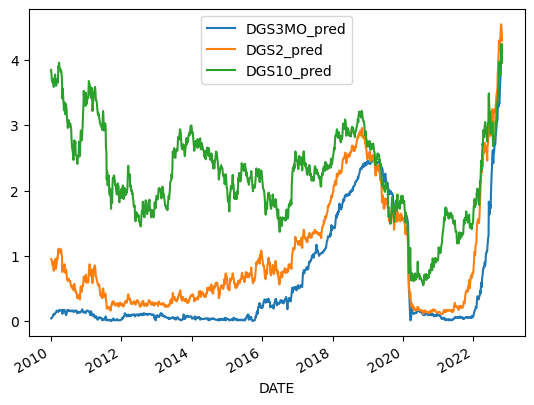

In [9]:
Y.plot()

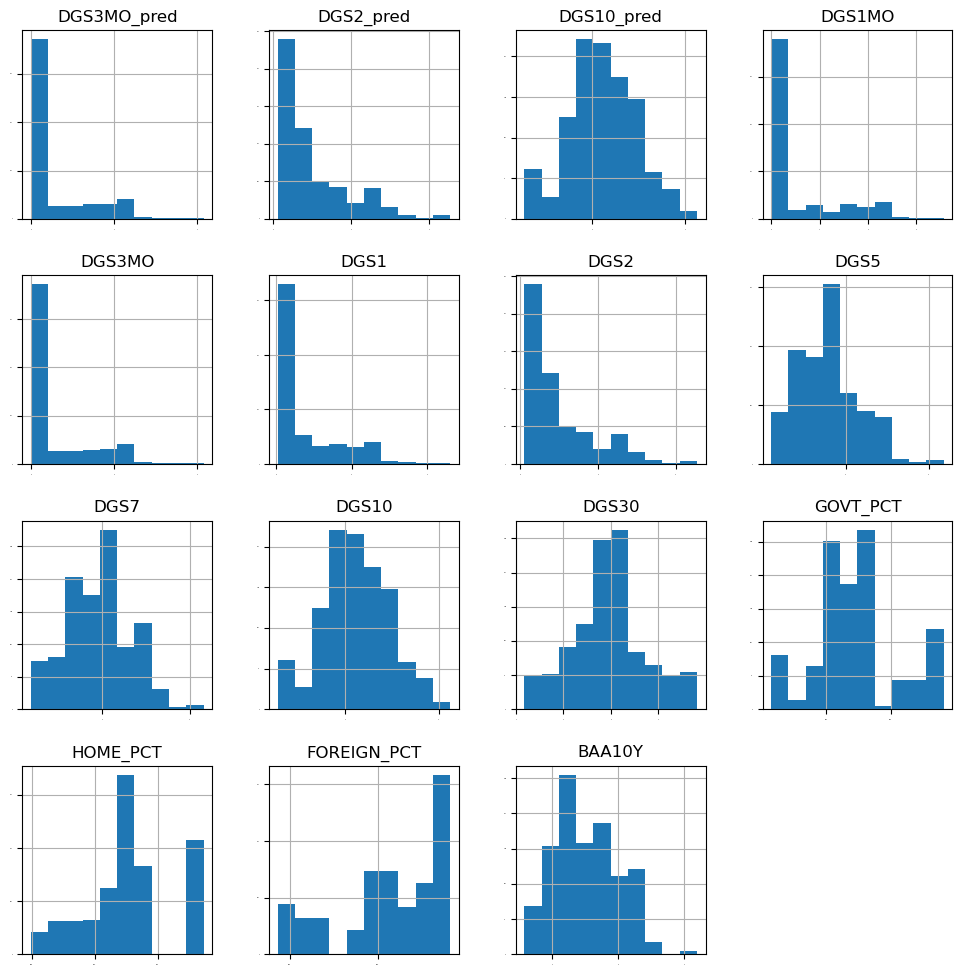

In [10]:
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(12,12))
pyplot.show()

The data appears to be skewed for certain variables. We could consider scaling and transforming it.

<AxesSubplot:>

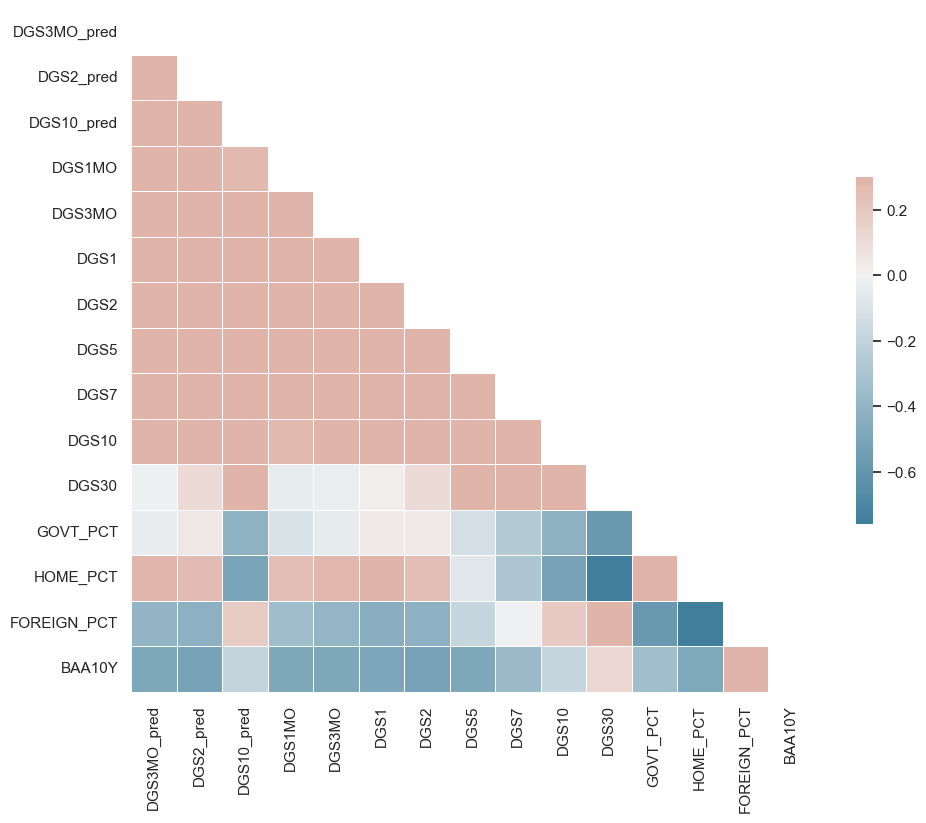

In [11]:
sns.set_theme(style="white")
corr = dataset.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

<AxesSubplot:title={'center':'Correlation Matrix'}>

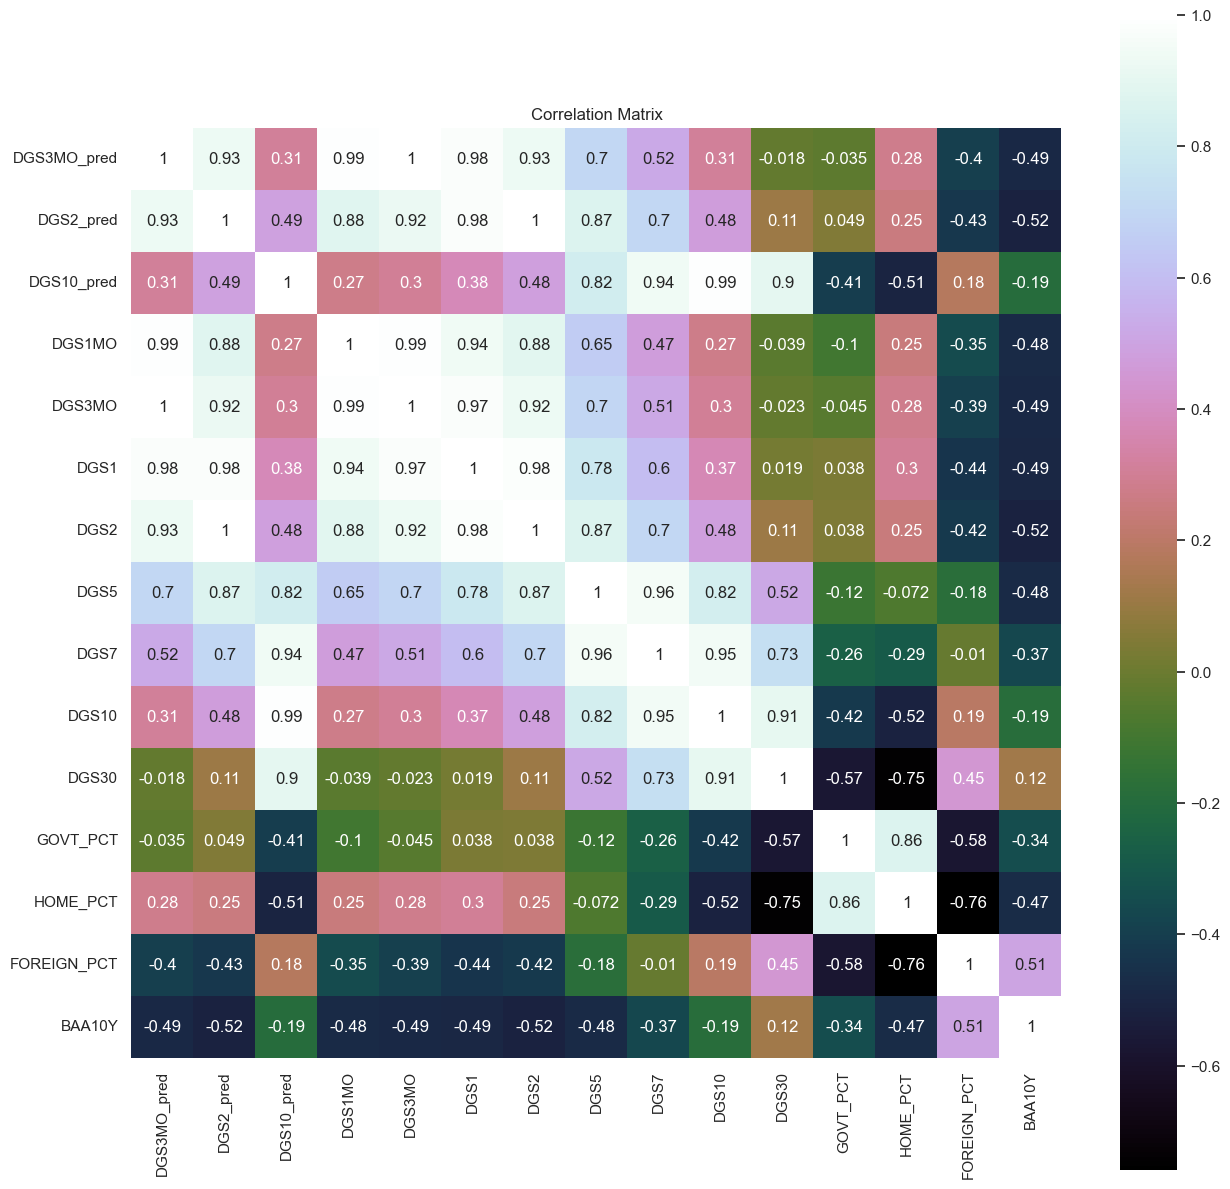

In [12]:
correlation = dataset.corr()
pyplot.figure(figsize=(15,15))
pyplot.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

Form the correlation plots we see a negative correlation with the corporate spread and the treasury bonds. We also see mostly positive correlation with the treasuries and different tenors, and as expected a strong correlation between the predicted and current time period of treasury tenor.

<Figure size 1500x1500 with 0 Axes>

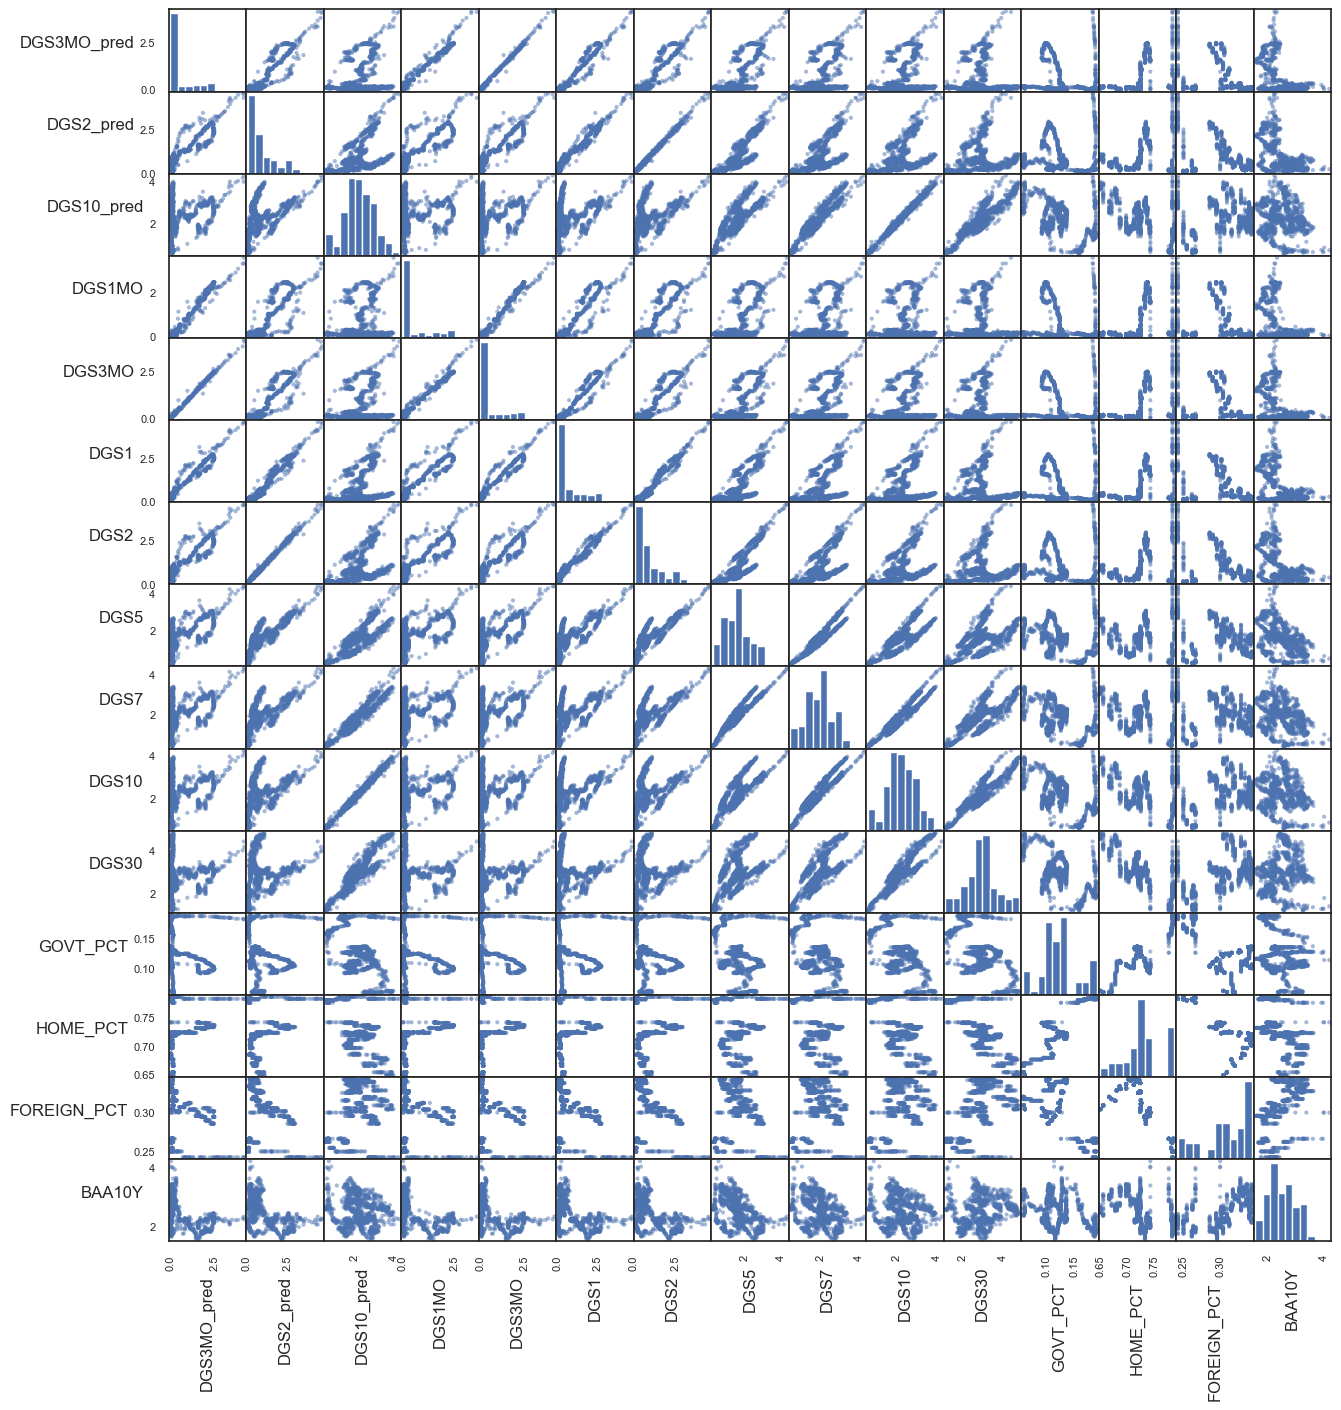

In [13]:
pyplot.figure(figsize=(15,15))
axes = scatter_matrix(dataset,figsize=(15,16))
for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_ha('right')
pyplot.show()

Lets have a look at the time series analysis  of the tenors we are trying to predict.

#### 3 Month

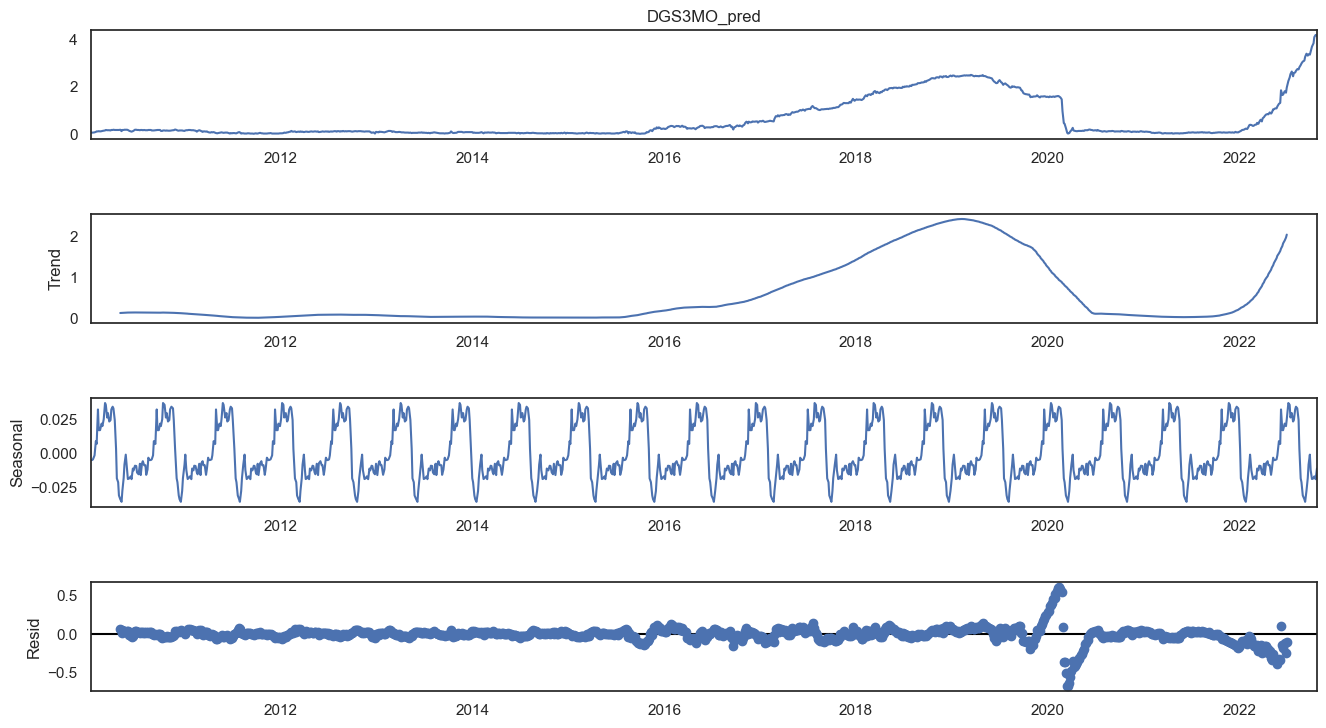

In [14]:
temp_Y = dataset['DGS3MO_pred']
res = sm.tsa.seasonal_decompose(temp_Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

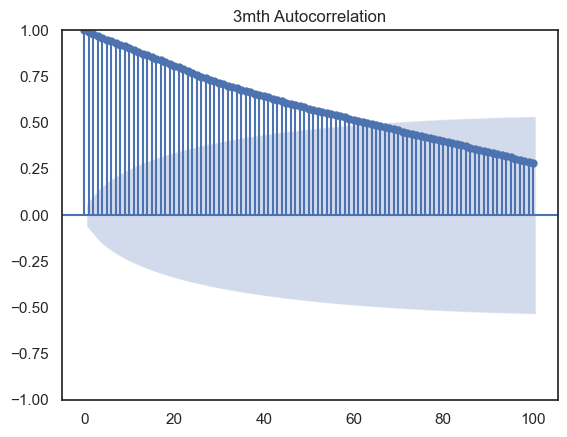

In [15]:
plot_acf(dataset["DGS3MO_pred"], lags=100)
plt.title("3mth Autocorrelation")
plt.show()

#### 2 Year

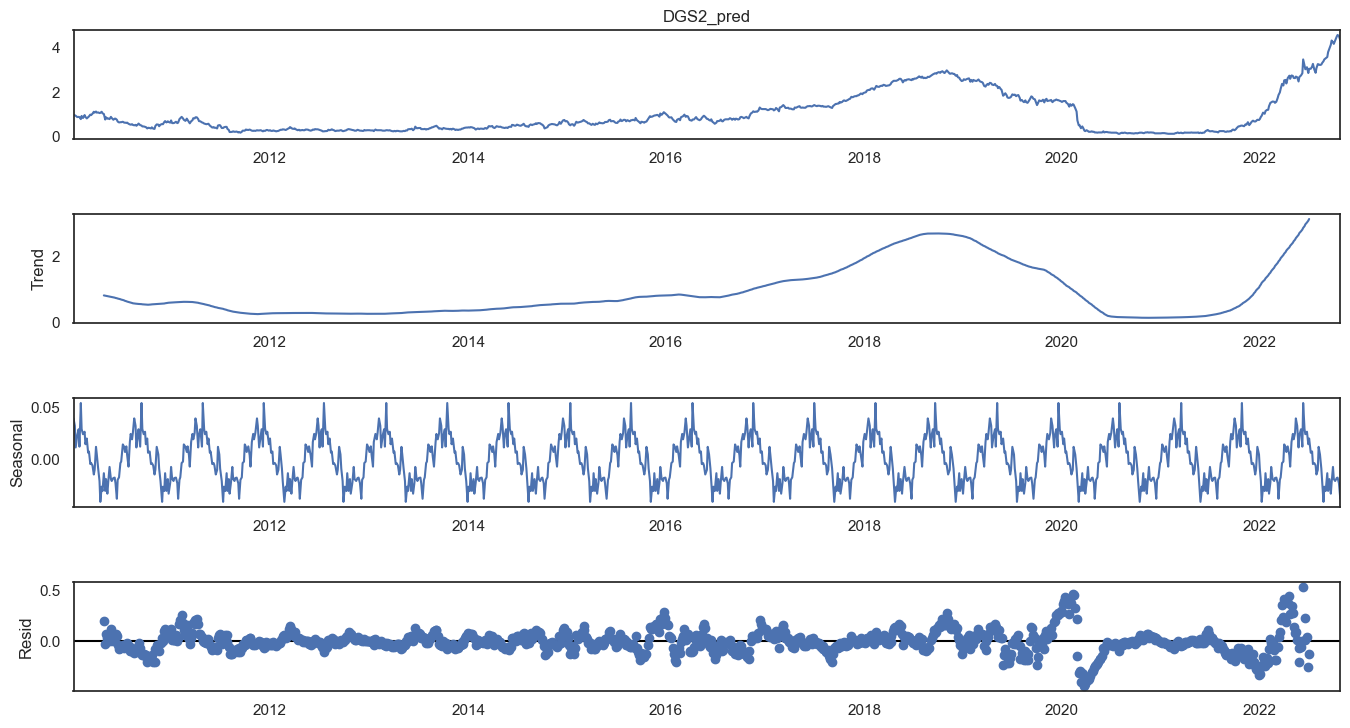

In [16]:
temp_Y = dataset['DGS2_pred']
res = sm.tsa.seasonal_decompose(temp_Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

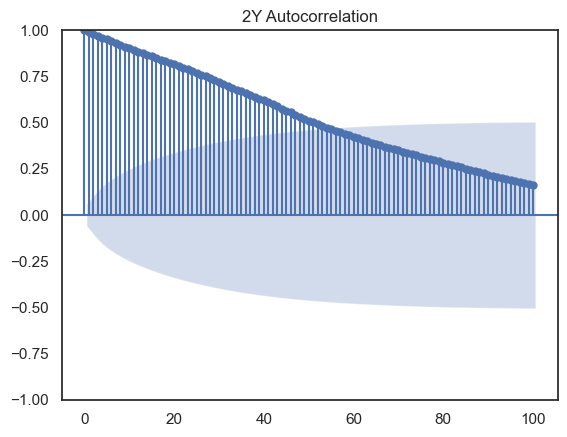

In [17]:
plot_acf(dataset["DGS2_pred"], lags=100)
plt.title("2Y Autocorrelation")
plt.show()

#### 10 Year

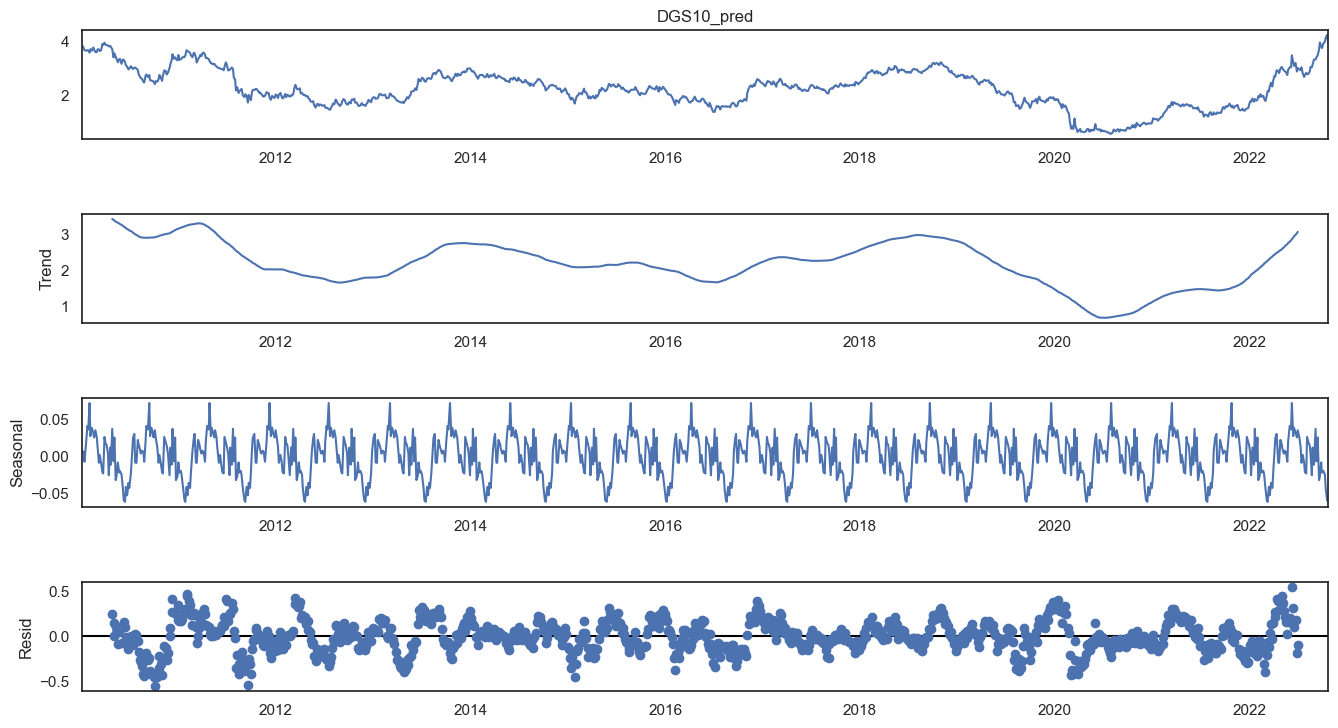

In [18]:
temp_Y = dataset['DGS10_pred']
res = sm.tsa.seasonal_decompose(temp_Y,period=52)
fig = res.plot()
fig.set_figheight(8)
fig.set_figwidth(15)
pyplot.show()

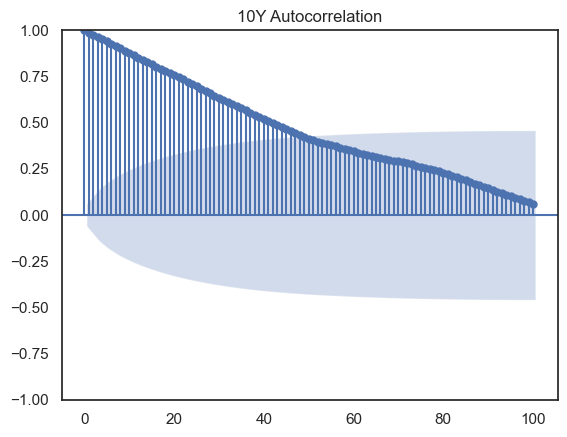

In [19]:
plot_acf(dataset["DGS10_pred"], lags=100)
plt.title("10Y Autocorrelation")
plt.show()

We see a regime change due to the impact of covid in 2020, which is much more pronounced in the 3mth and 2y then it is in the 10y. Trends are also clearly visible in the 3mth and 2y, but less so in the 10y. From the autocorrelation plots we also see a strong correlation with lagged variables up until the 50 to 60 differences (of 3 day periods). It would therefore probably be worth investigating models with time differences.

## Feature Selection

In [20]:
bestfeatures = SelectKBest(k=5, score_func=f_regression)
for col in Y.columns:
    temp_Y = dataset[col]
    temp_X = dataset.loc[:, X.columns]
    fit = bestfeatures.fit(temp_X,temp_Y)
    dfscores = pd.DataFrame(fit.scores_)
    dfcolumns = pd.DataFrame(X.columns)
    featureScores = pd.concat([dfcolumns,dfscores],axis=1)
    featureScores.columns = ['Specs','Score']
    print(col)
    print(featureScores.nlargest(10,'Score'))
    print('--------------')

DGS3MO_pred
          Specs          Score
1        DGS3MO  394371.910715
0        DGS1MO   46526.040483
2          DGS1   21585.578897
3          DGS2    6803.990979
4          DGS5    1057.011362
5          DGS7     401.312767
11       BAA10Y     335.535204
10  FOREIGN_PCT     205.049367
6         DGS10     114.792179
9      HOME_PCT      94.163213
--------------
DGS2_pred
          Specs          Score
3          DGS2  222075.559737
2          DGS1   24983.173479
1        DGS3MO    5864.637280
0        DGS1MO    3622.506074
4          DGS5    3238.146086
5          DGS7    1036.387010
11       BAA10Y     391.997104
6         DGS10     317.688114
10  FOREIGN_PCT     238.884104
9      HOME_PCT      74.806417
--------------
DGS10_pred
      Specs         Score
6     DGS10  70608.774621
5      DGS7   8723.864972
7     DGS30   4494.216784
4      DGS5   2229.344931
9  HOME_PCT    371.585656
3      DGS2    325.579857
8  GOVT_PCT    215.254710
2      DGS1    176.131413
1    DGS3MO    109.66

It should not come as a suprise that for each of the predicted variables, the most important feature is just the lagged time period of that feature.

## Evaluate Some Models Quickly

In [21]:
validation_size = 0.2
seed = 10
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [22]:
num_folds = 10
scoring = 'neg_mean_squared_error'

In [23]:
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso(random_state=seed)))
models.append(('EN', ElasticNet(random_state=seed)))
models.append(('CART', DecisionTreeRegressor(random_state=seed)))
models.append(('RF', RandomForestRegressor(random_state=seed)))
models.append(('MLP', MLPRegressor(random_state=seed)))

In [24]:
kfold_results = []
names = []
validation_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    names.append(name)

    res = model.fit(X_train, Y_train)
    validation_result = np.mean(np.square(res.predict(X_validation) - Y_validation), axis=0)
    validation_results.append(validation_result)
    train_result = np.mean(np.square(res.predict(X_train) - Y_train), axis=0)
    train_results.append(train_result)
    
    msg = "%s: \nAverage CV error: %s \nStd CV Error: (%s) \nTraining Error:\n%s \nTest Error:\n%s" % \
    (name, str(cv_results.mean()), str(cv_results.std()), str(train_result), str(validation_result))
    print(msg)
    print('----------')

LR: 
Average CV error: 0.004432663935268551 
Std CV Error: (0.0013853844709494588) 
Training Error:
DGS3MO_pred    0.001461
DGS2_pred      0.003732
DGS10_pred     0.007475
dtype: float64 
Test Error:
DGS3MO_pred    0.002233
DGS2_pred      0.002930
DGS10_pred     0.007984
dtype: float64
----------
LASSO: 
Average CV error: 0.6627168727588729 
Std CV Error: (0.09433902242270926) 
Training Error:
DGS3MO_pred    0.691466
DGS2_pred      0.771067
DGS10_pred     0.521251
dtype: float64 
Test Error:
DGS3MO_pred    0.789966
DGS2_pred      0.816233
DGS10_pred     0.475187
dtype: float64
----------
EN: 
Average CV error: 0.4518967414513468 
Std CV Error: (0.07069868790547437) 
Training Error:
DGS3MO_pred    0.421331
DGS2_pred      0.422341
DGS10_pred     0.503272
dtype: float64 
Test Error:
DGS3MO_pred    0.481363
DGS2_pred      0.441661
DGS10_pred     0.458928
dtype: float64
----------
CART: 
Average CV error: 0.008815692773768155 
Std CV Error: (0.0026590325720153058) 
Training Error:
DGS3MO_pr

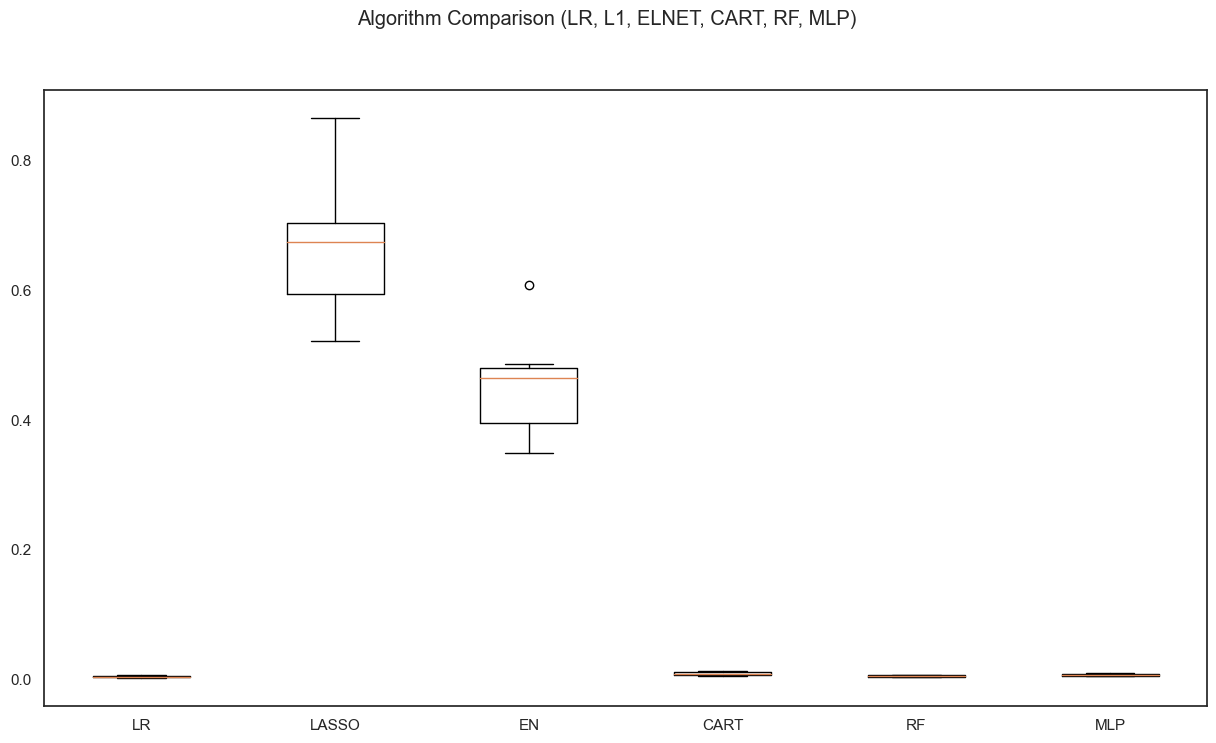

In [25]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison (LR, L1, ELNET, CART, RF, MLP)')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

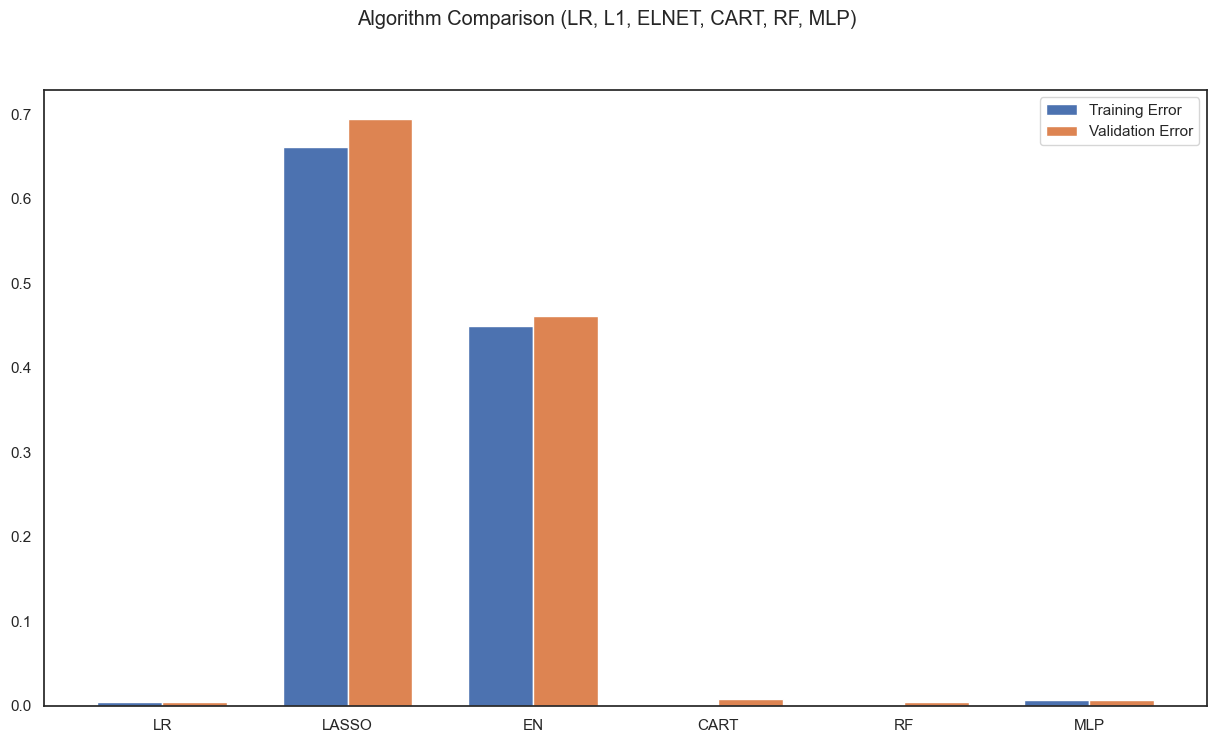

In [26]:
fig = pyplot.figure()
ind = np.arange(len(names))
width = 0.35
fig.suptitle('Algorithm Comparison (LR, L1, ELNET, CART, RF, MLP)')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, [x.mean() for x in train_results],  width=width, label='Training Error')
pyplot.bar(ind + width/2, [x.mean() for x in validation_results], width=width, label='Validation Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

In [27]:
models = []
models.append(('LR', LinearRegression()))
models.append(('CART', DecisionTreeRegressor(random_state=seed)))
models.append(('RF', RandomForestRegressor(random_state=seed)))
models.append(('MLP', MLPRegressor(random_state=seed)))
kfold_results = []
names = []
validation_results = []
train_results = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    kfold_results.append(cv_results)
    names.append(name)

    res = model.fit(X_train, Y_train)
    validation_result = np.mean(np.square(res.predict(X_validation) - Y_validation), axis=0)
    validation_results.append(validation_result)
    train_result = np.mean(np.square(res.predict(X_train) - Y_train), axis=0)
    train_results.append(train_result)

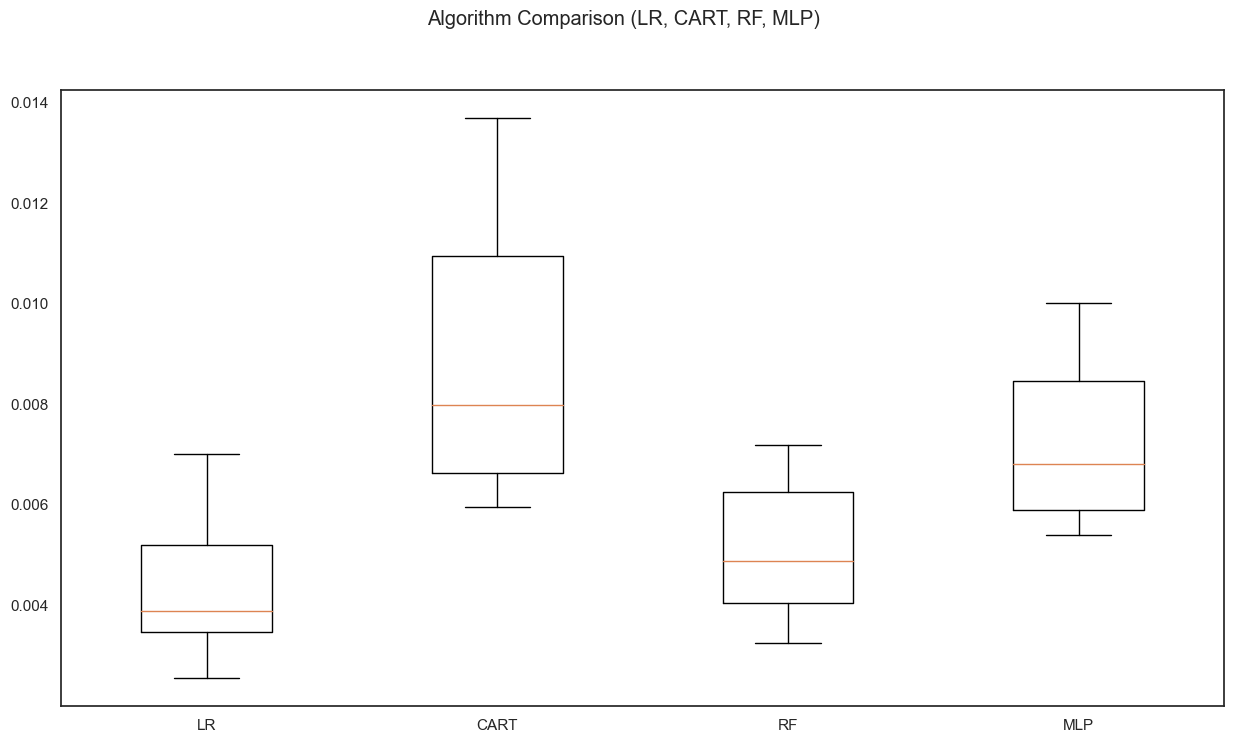

In [28]:
fig = pyplot.figure()
fig.suptitle('Algorithm Comparison (LR, CART, RF, MLP)')
ax = fig.add_subplot(111)
pyplot.boxplot(kfold_results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
pyplot.show()

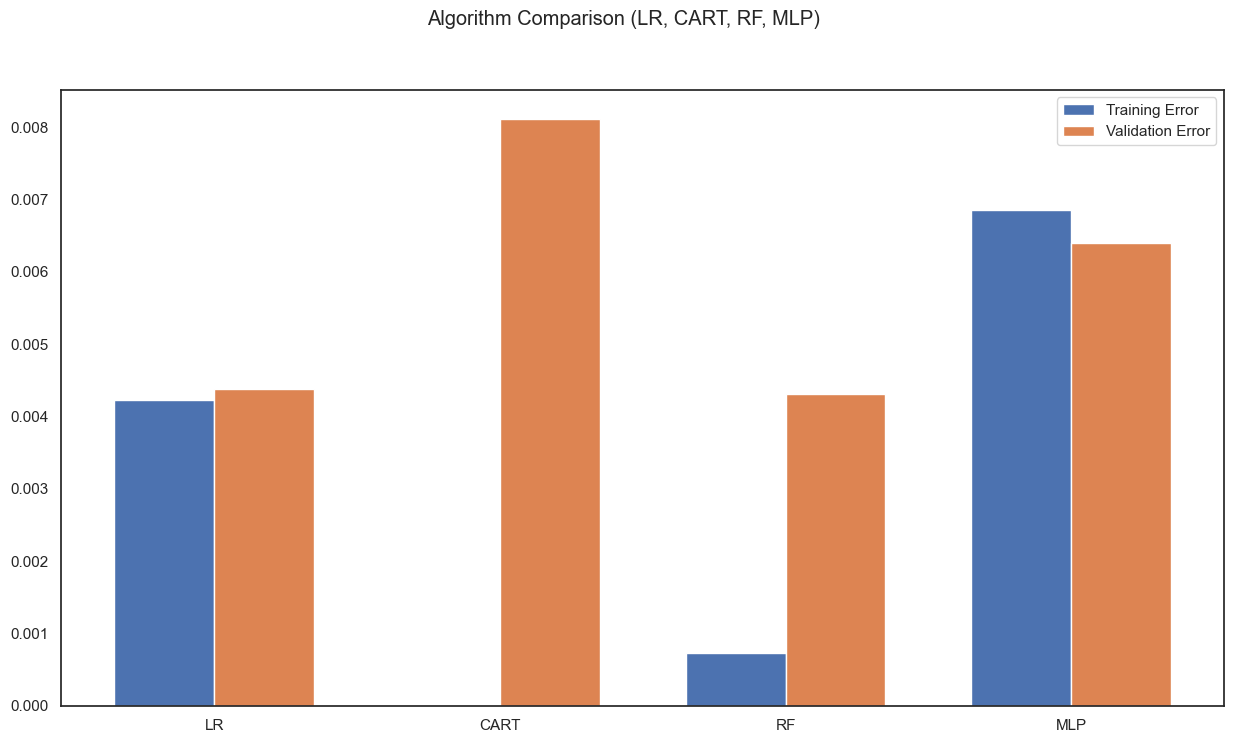

In [29]:
fig = pyplot.figure()
ind = np.arange(len(names))
width = 0.35
fig.suptitle('Algorithm Comparison (LR, CART, RF, MLP)')
ax = fig.add_subplot(111)
pyplot.bar(ind - width/2, [x.mean() for x in train_results],  width=width, label='Training Error')
pyplot.bar(ind + width/2, [x.mean() for x in validation_results], width=width, label='Validation Error')
fig.set_size_inches(15,8)
pyplot.legend()
ax.set_xticks(ind)
ax.set_xticklabels(names)
pyplot.show()

## Tuning the ANN

In [30]:
param_grid={'hidden_layer_sizes': [(20,), (50,), (20,20), (20, 30, 20)]}
model = MLPRegressor(random_state=seed, max_iter=5000)
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.007557 using {'hidden_layer_sizes': (20, 30, 20)}
-0.015199 (0.003579) with: {'hidden_layer_sizes': (20,)}
-0.009097 (0.001183) with: {'hidden_layer_sizes': (50,)}
-0.010969 (0.002263) with: {'hidden_layer_sizes': (20, 20)}
-0.007557 (0.001521) with: {'hidden_layer_sizes': (20, 30, 20)}


Optimal MLP has 3 hidden layers with 20, 30, 20 units in each.

## Compariing LR and MLP

In [31]:
model = MLPRegressor(hidden_layer_sizes= (20, 30, 20), random_state=seed)
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)
mse_MLP = mean_squared_error(Y_validation, predictions)
r2_MLP = r2_score(Y_validation, predictions)

model_2 = LinearRegression()
model_2.fit(X_train, Y_train)
predictions_2 = model_2.predict(X_validation)
mse_LR = mean_squared_error(Y_validation, predictions_2)
r2_LR = r2_score(Y_validation, predictions_2)


print("MSE LR = %f, MSE MLP = %f" % (mse_LR, mse_MLP ))
print("R2 LR = %f, R2 MLP = %f" % (r2_LR, r2_MLP ))

MSE LR = 0.004382, MSE MLP = 0.006553
R2 LR = 0.992230, R2 MLP = 0.988608


The LR and MLP models are comparable in performance with the LR model having a slight upperhand. Lets see how they perfom on the test set.

### Predictions

In [32]:
train_size = int(len(X) * (1-validation_size))
X_train, X_validation = X[0:train_size], X[train_size:len(X)]
Y_train, Y_validation = Y[0:train_size], Y[train_size:len(X)]

modelMLP = MLPRegressor(hidden_layer_sizes= (20,30,20), random_state=seed)
modelLR = LinearRegression()
modelRF = RandomForestRegressor(random_state=seed)

model_MLP = modelMLP.fit(X_train, Y_train)
model_LR = modelLR.fit(X_train, Y_train)

Y_predMLP = pd.DataFrame(model_MLP.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)

Y_predLR = pd.DataFrame(model_LR.predict(X_validation), index=Y_validation.index,
                      columns=Y_validation.columns)

<AxesSubplot:xlabel='DATE'>

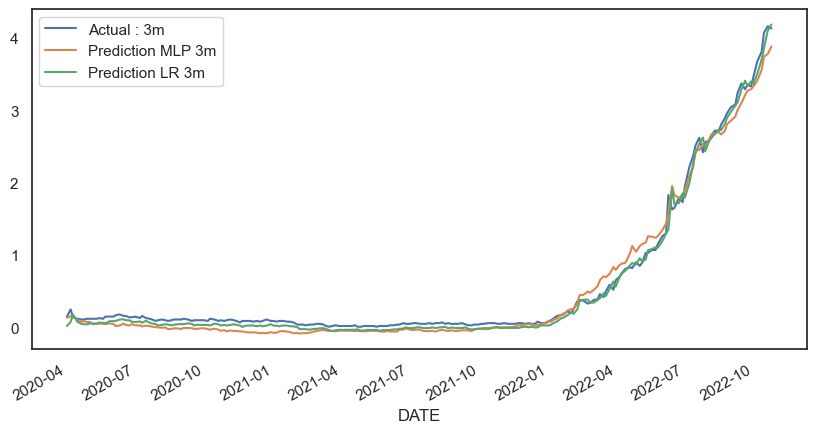

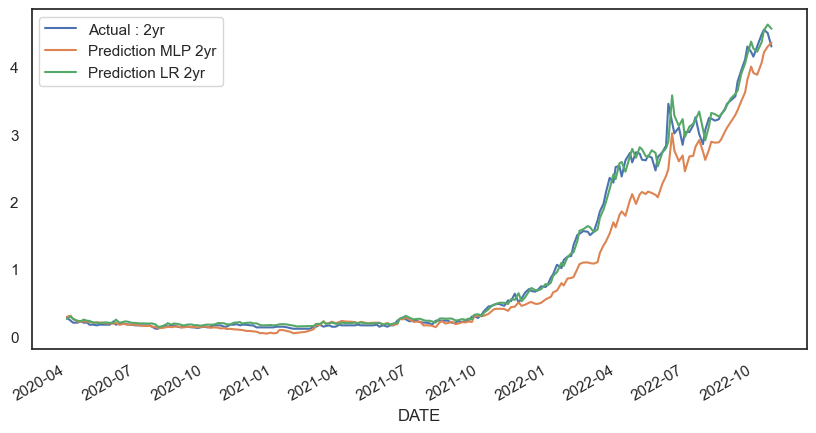

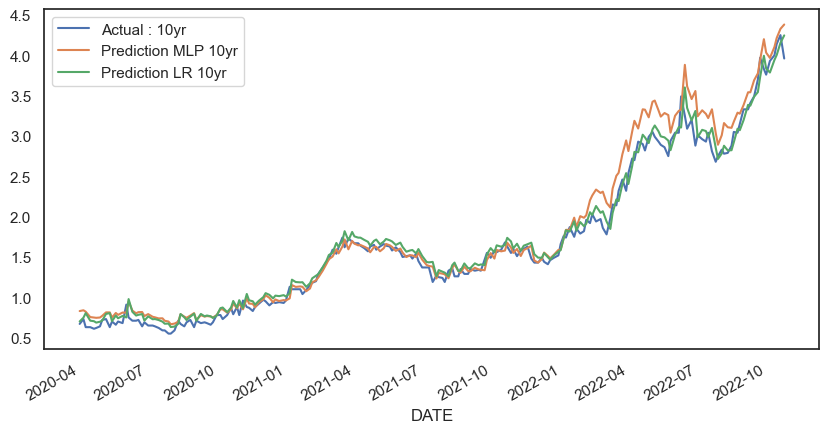

In [33]:
pd.DataFrame({'Actual : 3m': Y_validation.loc[:, 'DGS3MO_pred'],
              'Prediction MLP 3m': Y_predMLP.loc[:, 'DGS3MO_pred'],
              'Prediction LR 3m': Y_predLR.loc[:, 'DGS3MO_pred']}).plot(figsize=(10,5))

pd.DataFrame({'Actual : 2yr': Y_validation.loc[:, 'DGS2_pred'],
              'Prediction MLP 2yr': Y_predMLP.loc[:, 'DGS2_pred'],
              'Prediction LR 2yr': Y_predLR.loc[:, 'DGS2_pred']}).plot(figsize=(10,5))

pd.DataFrame({'Actual : 10yr': Y_validation.loc[:, 'DGS10_pred'],
              'Prediction MLP 10yr': Y_predMLP.loc[:, 'DGS10_pred'],
              'Prediction LR 10yr': Y_predLR.loc[:, 'DGS10_pred']}).plot(figsize=(10,5))

We see that actually the LR model is quite powerful, and outperforming the MLP model despite its complexity. Don't discount the power of simple models. Complex models and their ability to overfit can translate into worse outcomes than simpler models with higher bias and lower variance. Indeed in this example, LR is a good predictor for one-period forward predictions of treasury prices.

There is much more tuning that could be done and improvement to this model. For instance there are a number of further steps we could take:
- Try different models (more complex ones)
- Regularise our models
- Spend more time tuning complex models
- Use the difference in the time series data and predict those
- Feature engineering (additional features, scaling and transforming our data)

## References
Adapted from *Machine Learning & Data Science Blueprints for Finance*; Tatsat et al.